In [1]:
import sys
from pathlib import Path
parent_dir = Path().resolve().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from Bio import SeqIO

2025-12-15 23:14:38.086009: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-15 23:14:38.426203: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-15 23:14:39.524529: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Read ../data//Train/train_sequences.fasta
Loaded Training sequence size: 82404
Read ../data//Train/train_terms.tsv
Loaded Training sequence size: 82404
Removing sequences longer than 2375.0 (Top 1%)


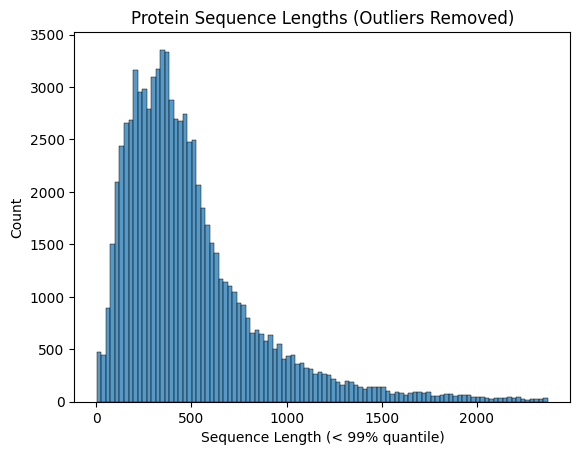

Original size: 82404, New size: 81578
--- Filtering terms with frequency <= 10 ---
Unique terms decrease from: 26125 to 7257
Removed 1501 proteins that became empty after filtering.
Final DataFrame shape: (80903, 2)
Training dataframe size: 80089
           ID                                           Sequence  \
0  A0A0C5B5G6                                   MRWQEMGYIFYPRKLR   
1      A0JNW5  MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...   
2      A0JP26  MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...   

                                                term  
0  [GO:0001649, GO:0033687, GO:0005615, GO:000563...  
1  [GO:0120013, GO:0034498, GO:0005769, GO:012000...  
2                                       [GO:0005515]  


,ID,Sequence,term
0,A0A0C5B5G6,MRWQEMGYIFYPRKLR,"[GO:0001649, GO:0033687, GO:0005615, GO:000563..."
1,A0JNW5,MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...,"[GO:0120013, GO:0034498, GO:0005769, GO:012000..."
2,A0JP26,MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...,[GO:0005515]
3,A0PK11,MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...,"[GO:0007605, GO:0005515]"
4,A1A4S6,MGLQPLEFSDCYLDSPWFRERIRAHEAELERTNKFIKELIKDGKNL...,"[GO:0005829, GO:0010008, GO:0005515, GO:000509..."


In [3]:
from preprocessing.data_preprocessing import ProteinDataProcessor, create_dataset_with_emb

train_path = '../data/'
processor = ProteinDataProcessor(train_path, 'str')
train_df, info = processor.prepare_training_data()

display(train_df.head())

In [4]:
test_ids_path = '../data/embedding/esm/test_ids.npy'
test_ids = np.load(test_ids_path, allow_pickle=True)
train_ids = train_df["ID"].to_list()

train_emb, test_emb = create_dataset_with_emb(train_ids, test_ids, "esm")

print("Train size:", len(train_ids), "\nTest size:", len(test_ids))
print("Embedding shape:", train_emb.shape)

Train size: 80089 
Test size: 224309
Embedding shape: (80089, 1280)


In [6]:
from sklearn.preprocessing import MultiLabelBinarizer
import pickle

# Label
valid_label = set()
for subl in train_df.term:
  valid_label.update([label for label in subl])
valid_label = sorted(list(valid_label))

print("Number of valid class:", len(valid_label))

def create_label(valid_label: list, train_df: pd.DataFrame):
  mlb = MultiLabelBinarizer()
  label = mlb.fit_transform(train_df["term"])

  return label, mlb

Number of valid class: 7256


In [7]:
X_train = train_emb
Y_train, mlb = create_label(valid_label, train_df)

print("Label shape:", Y_train.shape)
print("Input shape:", X_train.shape)

Label shape: (80089, 7256)
Input shape: (80089, 1280)


# MLP model

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class ProteinClassifier(nn.Module):
    def __init__(self, input_dim=1024, num_classes=7256, dropout_rate=0.3):
        super(ProteinClassifier, self).__init__()

        self.network = nn.Sequential(
            # Layer 1: 
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),      
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # Layer 2: 
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # Output Layer:
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.network(x)

In [8]:
class GO_Dataset(Dataset):
    def __init__(self, embeddings, labels):
        # embeddings: numpy array (N, 1024)
        # labels: binary matrix (N, num_classes)
        self.X = torch.tensor(embeddings, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Training

In [ ]:
num_classes = Y_train.shape[1]
input_dim = X_train.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparam and loss func
model = ProteinClassifier(input_dim=input_dim, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

# Dataloader
train_dataset = GO_Dataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

num_epochs = 20
print("Start Training...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        # Loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Start Training...
Epoch [1/20], Loss: 0.0137
Epoch [2/20], Loss: 0.0047
Epoch [3/20], Loss: 0.0045
Epoch [4/20], Loss: 0.0043
Epoch [5/20], Loss: 0.0042
Epoch [6/20], Loss: 0.0041
Epoch [7/20], Loss: 0.0040
Epoch [8/20], Loss: 0.0039
Epoch [9/20], Loss: 0.0038
Epoch [10/20], Loss: 0.0038
Epoch [11/20], Loss: 0.0037
Epoch [12/20], Loss: 0.0037
Epoch [13/20], Loss: 0.0037
Epoch [14/20], Loss: 0.0036
Epoch [15/20], Loss: 0.0036
Epoch [16/20], Loss: 0.0036
Epoch [17/20], Loss: 0.0035
Epoch [18/20], Loss: 0.0035
Epoch [19/20], Loss: 0.0035
Epoch [20/20], Loss: 0.0035


In [13]:
def save_artifacts(model, model_path="cafa_model.pth"):
    torch.save(model.state_dict(), model_path)
    print(f"Saved model weights to {model_path}")

save_artifacts(model)

Saved model weights to cafa_model.pth


In [14]:
import gc

del X_train, Y_train
gc.collect()

5896

# Inference and submit

In [ ]:
import csv
from tqdm import tqdm
from torch.utils.data import TensorDataset

test_tensor = torch.tensor(test_emb, dtype=torch.float32)
test_dataset = TensorDataset(test_tensor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
test_ids = np.array(test_ids)
target_terms = mlb.classes_

THRESHOLD = 0.01
output_file = 'submission.tsv'
model.eval()
print(f"Writing to {output_file}...")

with open(output_file, 'w', newline='') as f:
    writer = csv.writer(f, delimiter='\t')

    current_idx = 0

    with torch.no_grad():
        for inputs in tqdm(test_loader):
            if isinstance(inputs, list) or isinstance(inputs, tuple):
                inputs = inputs[0]

            inputs = inputs.to(device)
            logits = model(inputs)
            probs = torch.sigmoid(logits) # (Batch_size, 7256)

            rows, cols = torch.where(probs > THRESHOLD)
            scores = probs[rows, cols]

            rows = rows.cpu().numpy()
            cols = cols.cpu().numpy()
            scores = scores.cpu().numpy()

            # 4. Ánh xạ về ID thực và Term thực
            batch_real_ids = test_ids[current_idx + rows]
            batch_real_terms = target_terms[cols]

            # 5. Ghi vào file
            # Zip lại thành từng dòng: (ID, Term, Score)
            rows_to_write = zip(batch_real_ids, batch_real_terms, scores)
            writer.writerows(rows_to_write)

            # Cập nhật vị trí index cho batch sau
            current_idx += inputs.size(0)

print("Created submission.tsv!")

Writing to submission.tsv...


100%|██████████| 14020/14020 [00:43<00:00, 319.00it/s]

Created submission.tsv!
